### **Foundation**

Use Python to fetch XAUUSDc H1 candles data from MT5, but by calling 10 daily candles. UTC-based timezone. Use the plotly white-themed default candlestick chart with tick-volume bars on separte pane. Remove the rangeslider, make the chart height = 900.

Identify trading-hours that include pre-market open and overnight from the very first candle formed to the last candle formed. Locate the very first and project virtical dashed line at it, and project another dashed line at the last candle. Do this for all days.


In [2]:
import MetaTrader5 as mt5
import pandas as pd
import pytz
from datetime import datetime, timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# -------------------------------------------------
# PARAMETERS
# -------------------------------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_H1
lookback_days = 10
utc_timezone = pytz.UTC

# -------------------------------------------------
# INITIALIZE MT5
# -------------------------------------------------
if not mt5.initialize():
    raise RuntimeError(f"MT5 initialization failed: {mt5.last_error()}")

if not mt5.symbol_select(symbol, True):
    mt5.shutdown()
    raise RuntimeError(f"Symbol not available: {symbol}")

# -------------------------------------------------
# FETCH DATA (UTC)
# -------------------------------------------------
utc_now = datetime.now(utc_timezone)
utc_from = utc_now - timedelta(days=lookback_days + 1)

rates = mt5.copy_rates_range(
    symbol,
    timeframe,
    utc_from,
    utc_now
)

mt5.shutdown()

if rates is None or len(rates) == 0:
    raise RuntimeError("No data returned from MT5")

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s", utc=True)
df.set_index("time", inplace=True)

# -------------------------------------------------
# IDENTIFY TRADING DAYS
# -------------------------------------------------
df["trade_date"] = df.index.date

daily_bounds = (
    df.groupby("trade_date")
    .agg(
        first_time=("trade_date", lambda x: x.index.min()),
        last_time=("trade_date", lambda x: x.index.max())
    )
)

# -------------------------------------------------
# PLOTLY FIGURE (2 PANES)
# -------------------------------------------------
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    row_heights=[0.75, 0.25],
    subplot_titles=("XAUUSDc H1", "Tick Volume")
)

# -------------------------------------------------
# CANDLESTICKS
# -------------------------------------------------
fig.add_trace(
    go.Candlestick(
        x=df.index,
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"],
        name="XAUUSDc"
    ),
    row=1,
    col=1
)

# -------------------------------------------------
# TICK VOLUME
# -------------------------------------------------
fig.add_trace(
    go.Bar(
        x=df.index,
        y=df["tick_volume"],
        name="Tick Volume"
    ),
    row=2,
    col=1
)

# -------------------------------------------------
# DAILY FIRST / LAST VERTICAL LINES
# -------------------------------------------------
for _, row in daily_bounds.iterrows():
    fig.add_vline(
        x=row["first_time"],
        line_width=1,
        line_dash="dash",
        line_color="gray"
    )
    fig.add_vline(
        x=row["last_time"],
        line_width=1,
        line_dash="dash",
        line_color="gray"
    )

# -------------------------------------------------
# LAYOUT
# -------------------------------------------------
fig.update_layout(
    title="XAUUSDc H1 – Trading Day Boundaries (UTC)",
    height=900,
    xaxis_rangeslider_visible=False,
    showlegend=False,
    template="plotly_white",
)

fig.show()


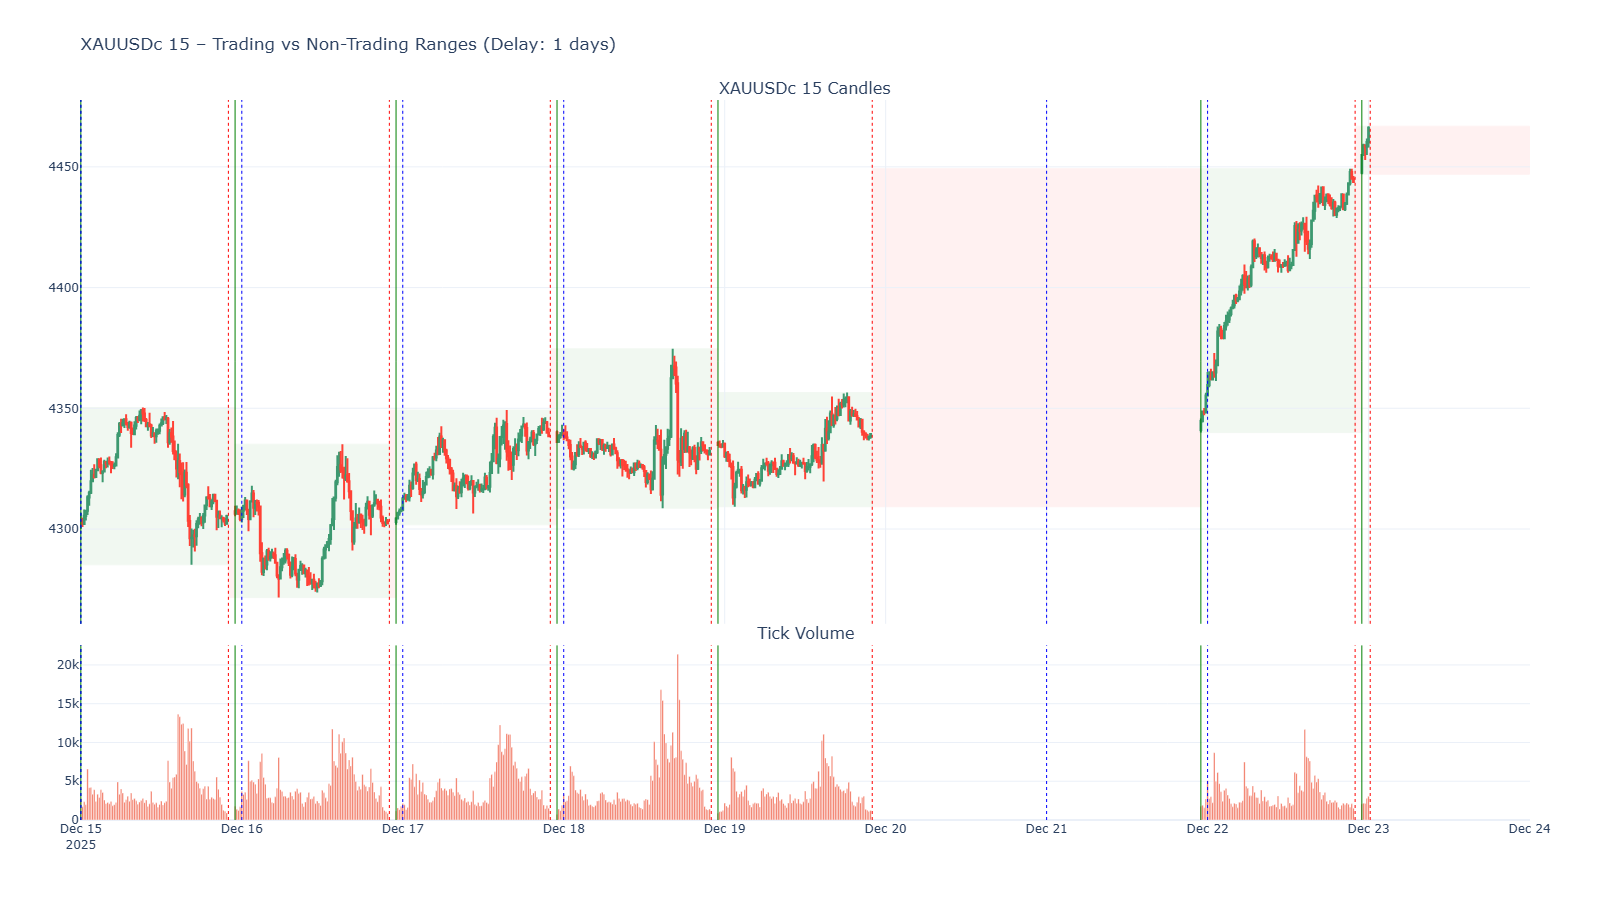

In [10]:
import MetaTrader5 as mt5
import pandas as pd
import pytz
from datetime import datetime, timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# -------------------------------------------------
# PARAMETERS
# -------------------------------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M15   # can be any MT5 timeframe
lookback_days = 8              # number of days to look back
delay_days = 1                 # adjustable delay (days back from today)
utc_timezone = pytz.UTC

# -------------------------------------------------
# HELPER: Convert MT5 timeframe to timedelta
# -------------------------------------------------
def timeframe_to_timedelta(tf):
    mapping = {
        mt5.TIMEFRAME_M1: timedelta(minutes=1),
        mt5.TIMEFRAME_M2: timedelta(minutes=2),
        mt5.TIMEFRAME_M3: timedelta(minutes=3),
        mt5.TIMEFRAME_M4: timedelta(minutes=4),
        mt5.TIMEFRAME_M5: timedelta(minutes=5),
        mt5.TIMEFRAME_M6: timedelta(minutes=6),
        mt5.TIMEFRAME_M10: timedelta(minutes=10),
        mt5.TIMEFRAME_M12: timedelta(minutes=12),
        mt5.TIMEFRAME_M15: timedelta(minutes=15),
        mt5.TIMEFRAME_M20: timedelta(minutes=20),
        mt5.TIMEFRAME_M30: timedelta(minutes=30),
        mt5.TIMEFRAME_H1: timedelta(hours=1),
        mt5.TIMEFRAME_H2: timedelta(hours=2),
        mt5.TIMEFRAME_H3: timedelta(hours=3),
        mt5.TIMEFRAME_H4: timedelta(hours=4),
        mt5.TIMEFRAME_H6: timedelta(hours=6),
        mt5.TIMEFRAME_H8: timedelta(hours=8),
        mt5.TIMEFRAME_H12: timedelta(hours=12),
        mt5.TIMEFRAME_D1: timedelta(days=1),
        mt5.TIMEFRAME_W1: timedelta(weeks=1),
        mt5.TIMEFRAME_MN1: timedelta(days=30),
    }
    return mapping.get(tf, timedelta(hours=1))  # default 1 hour

# -------------------------------------------------
# INITIALIZE MT5
# -------------------------------------------------
if not mt5.initialize():
    raise RuntimeError(f"MT5 initialization failed: {mt5.last_error()}")

if not mt5.symbol_select(symbol, True):
    mt5.shutdown()
    raise RuntimeError(f"Symbol not available: {symbol}")

# -------------------------------------------------
# FETCH DATA RANGE WITH DELAY
# -------------------------------------------------
utc_now = datetime.now(utc_timezone).replace(hour=0, minute=0, second=0, microsecond=0)
utc_now -= timedelta(days=delay_days)  # shift to yesterday or adjustable delay
utc_from = utc_now - timedelta(days=lookback_days)  # lookback window

rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_now)
mt5.shutdown()

if rates is None or len(rates) == 0:
    raise RuntimeError("No data returned from MT5")

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s", utc=True)
df.set_index("time", inplace=True)
df.sort_index(inplace=True)

# -------------------------------------------------
# DETECT TRADING SESSIONS
# -------------------------------------------------
candle_delta = timeframe_to_timedelta(timeframe)
df["gap"] = df.index.to_series().diff() > candle_delta
df["session"] = df["gap"].cumsum()

trading_sessions = []
non_trading_gaps = []

# Trading sessions: consecutive candles
for session_id, group in df.groupby("session"):
    trading_sessions.append({
        "x0": group.index.min(),
        "x1": group.index.max() + candle_delta,  # include last candle
        "y0": group["low"].min(),
        "y1": group["high"].max()
    })

# Non-trading gaps between sessions
for i in range(len(trading_sessions) - 1):
    gap_start = trading_sessions[i]["x1"]
    gap_end = trading_sessions[i + 1]["x0"]
    if gap_start < gap_end:
        non_trading_gaps.append({
            "x0": gap_start,
            "x1": gap_end,
            "y0": min(trading_sessions[i]["y0"], trading_sessions[i+1]["y0"]),
            "y1": max(trading_sessions[i]["y1"], trading_sessions[i+1]["y1"])
        })

# Gaps before first session and after last session
first_candle = trading_sessions[0]
last_candle = trading_sessions[-1]
day_start = datetime.combine(first_candle["x0"].date(), datetime.min.time()).replace(tzinfo=utc_timezone)
day_end = datetime.combine(last_candle["x1"].date(), datetime.max.time()).replace(tzinfo=utc_timezone)

if day_start < first_candle["x0"]:
    non_trading_gaps.insert(0, {"x0": day_start, "x1": first_candle["x0"], "y0": first_candle["y0"], "y1": first_candle["y1"]})
if last_candle["x1"] < day_end:
    non_trading_gaps.append({"x0": last_candle["x1"], "x1": day_end, "y0": last_candle["y0"], "y1": last_candle["y1"]})

# -------------------------------------------------
# PLOTLY FIGURE
# -------------------------------------------------
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    row_heights=[0.75, 0.25],
    subplot_titles=(f"{symbol} {timeframe} Candles", "Tick Volume")
)

# Candlesticks
fig.add_trace(
    go.Candlestick(
        x=df.index,
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"],
        name=symbol
    ),
    row=1,
    col=1
)

# Tick volume
fig.add_trace(
    go.Bar(
        x=df.index,
        y=df["tick_volume"],
        name="Tick Volume"
    ),
    row=2,
    col=1
)

# Trading sessions (green rectangles)
for session in trading_sessions:
    fig.add_shape(
        type="rect",
        x0=session["x0"],
        x1=session["x1"],
        y0=session["y0"],
        y1=session["y1"],
        line=dict(color="green", width=1),
        fillcolor="green",
        opacity=0.05,
        layer="below"
    )

# Non-trading gaps (red rectangles)
for gap in non_trading_gaps:
    fig.add_shape(
        type="rect",
        x0=gap["x0"],
        x1=gap["x1"],
        y0=gap["y0"],
        y1=gap["y1"],
        line=dict(color="red", width=1),
        fillcolor="red",
        opacity=0.05,
        layer="below"
    )

# -------------------------------------------------
# VERTICAL LINES: session start, session end, 0:00 UTC (all panes)
# -------------------------------------------------
for session in trading_sessions:
    session_start = session["x0"]
    session_end = session["x1"]
    day_midnight = datetime.combine(session_start.date(), datetime.min.time()).replace(tzinfo=utc_timezone)

    # 0:00 UTC vertical line
    fig.add_vline(x=day_midnight, line=dict(color="blue", width=1, dash="dot"), row="all", col=1)
    # Start of trading session
    fig.add_vline(x=session_start, line=dict(color="green", width=1, dash="solid"), row="all", col=1)
    # End of trading session
    fig.add_vline(x=session_end, line=dict(color="red", width=1, dash="dot"), row="all", col=1)

# -------------------------------------------------
# LAYOUT
# -------------------------------------------------
fig.update_layout(
    title=f"{symbol} {timeframe} – Trading vs Non-Trading Ranges (Delay: {delay_days} days)",
    height=900,
    xaxis_rangeslider_visible=False,
    showlegend=False,
    template="plotly_white"
)

fig.show()


The only downside for this is that its not ideal to directly translate this into live trading bot due to the delayed format. 